In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
import glob
from scipy import stats
from scrabble import Scrabble

sns.set_theme(color_codes=True)

In [23]:
files = glob.glob("results/*.csv")
small_dfs = []
for file in files:
    filename = file.split('/')[-1]
    language = filename.split('_')[0]
    tmp = pd.read_csv(file)
    tmp.loc[:, "language"] = language
    small_dfs.append(tmp)

df = pd.concat(small_dfs, ignore_index=True)

print("Total count of commits:", len(df.index))
print("Total quantity of code:", df['code_quantity'].sum())

df = df[df["code_quantity"] > 5]
df = df[df["code_quantity"] < 10000]
df = df[(np.abs(stats.zscore(df["code_quantity"])) < 3)]

# To protect the innocent!
df = df.drop(columns=['author', 'repo'])

df

Total count of commits: 52122
Total quantity of code: 205392450


,code_quantity,commit_quality,message,language
0,480,18,"Revert ""Update README.md""\n\nThis reverts comm...",python
1,243,18,"Revert ""Update README.md""\n\nThis reverts comm...",python
2,199,18,"Revert ""Update README.md""\n\nThis reverts comm...",python
4,554,9,Update README.md,python
5,367,9,Update README.md,python
...,...,...,...,...
52117,375,51,Note the maximum working node version is 10.x\...,html
52118,203,57,Merge pull request #1079 from foundation/depen...,html
52119,318,54,Merge pull request #1078 from foundation/depen...,html
52120,318,19,Bump color-string from 1.5.3 to 1.6.0\n\nBumps...,html


In [3]:
# Top and bottom vales
df.sort_values(by=['commit_quality'])

,code_quantity,commit_quality,message,language
44432,109,0,0.6.3,javascript
31695,2659,0,Reworked ISoundFormat.LengthInSeconds implemen...,c#
1316,307,0,HelloGitHub 五周年,python
8190,76,0,[代码优化](v2.6)：update README.md,java
8191,790,0,[代码优化](v2.6)：禁用用户后踢出用户Bug修复\n\nclose https://g...,java
...,...,...,...,...
33869,1032,124,Update grafana/regexp package to reject very d...,go
44701,1471,124,Instantiate models with new Model instead of O...,javascript
22184,302,128,Make it more clear in package.json which keys ...,typescript
38504,2079,137,Rename `proto_package_to_prefix_mappings_path`...,c++


In [4]:
worse = df[df["commit_quality"] >= 1]
worse = worse[worse["commit_quality"] < 5]
m = worse.apply(lambda d: (len(Scrabble.process_commit_message(str(d.message))) > 1), axis = 1)
worse = worse[m]
worse = worse.sort_values(by='commit_quality')
worse.to_csv('worst_commits.csv')

In [5]:
index = 45800
print(worse.loc[index,:])

code_quantity              1523
commit_quality                3
message           Run formatter
language             javascript
Name: 45800, dtype: object


In [6]:
# Worst scrabbles
for idx, best in worse[-400:-1].iterrows():
    words = Scrabble.process_commit_message(best.message)
    s = Scrabble()
    s.put_best_many(words)
    if (len(s.get_words()) < 2):
        continue
    print("Score {}: {}".format(best.commit_quality, ' '.join(words)))
    print("\tOriginal message: {}".format(best.message.split("\n")[0]))
    print("\tLanguage: {}".format(best.language))
    print(s)

Score 4: ascii changed to handle ddb
	Original message: febcdic-to-ascii changed to handle ddb
	Language: cobol
               
               
               
               
               
               
               
       to      
       o       
               
               
               
               
               
               

Score 4: not impleme in emscrip
	Original message: Backends: GLFW: glfwGetKeyName is not implemented in emscripten (#4907, #4858)
	Language: c++
               
               
               
               
               
               
               
       is      
       n       
               
               
               
               
               
               

Score 4: structu by default in header
	Original message: No structure by default in header
	Language: cobol
               
               
               
               
               
               
       i       
       no      
               
         

In [7]:
best = df.sort_values(by=['commit_quality'])[-500:-1]
best.loc[:, 'message_processed'] = [' '.join(Scrabble.process_commit_message(str(x))) for x in best.loc[:, 'message']]
best.to_csv('best_commits.csv')

In [8]:
# Best scrabbles
for idx, best in df.sort_values(by=['commit_quality'])[-5:-1].iterrows():
    words = Scrabble.process_commit_message(best.message)
    print("Score {}: {}".format(best.commit_quality, ' '.join(words)))
    print("\tOriginal message: {}".format(best.message.split("\n")[0]))
    print("\tLanguage: {}".format(best.language))
    s = Scrabble()
    s.put_best_many(words)
    print(s)

Score 124: Update grafana regexp package to reject very deeply nested regexps
	Original message: Update grafana/regexp package to reject very deeply nested regexps (#10397)
	Language: go
               
           v   
        reject 
    nested r   
        g  yr  
        e   e  
        x p g  
       update  
          cox  
          k p  
          a s  
          g    
        deeply 
               
               

Score 124: Instant models with new Model instead of Object create model for perform
	Original message: Instantiate models with new Model instead of Object.create(model) for performance.
	Language: javascript
               
               
         model 
         of    
         d     
      object w 
    f    l  ii 
    op instant 
   create   sh 
     r  w   t  
     f   model 
     o      a  
     r      d  
     m         
               

Score 128: Make it more clear in package json which keys will be include in publish pack
	Original message: Make it more cl

In [9]:
# Language averages
meanstats = df.groupby(['language']).mean()
meanstats = meanstats.reset_index()
print(meanstats.sort_values(by='code_quantity').reset_index(drop=True))

df_ord = df.copy()

for i, x in meanstats.sort_values(by='commit_quality').reset_index(drop=True).iterrows():
    df_ord.loc[df_ord["language"] == x["language"], "order_quality"] = i
for i, x in meanstats.sort_values(by='code_quantity').reset_index(drop=True).iterrows():
    df_ord.loc[df_ord["language"] == x["language"], "order_quantity"] = i


df_ord


      language  code_quantity  commit_quality
0         html     780.448985       28.041852
1   javascript     895.012434       29.426112
2            c     927.054706       29.558290
3       python    1011.469794       27.502987
4        cobol    1015.340850       22.755054
5   typescript    1048.999529       31.381424
6         rust    1060.765821       29.877616
7          c++    1127.425479       32.051505
8           go    1133.369413       30.191834
9           c#    1134.207410       27.973401
10        java    1154.118984       25.843635


,code_quantity,commit_quality,message,language,order_quality,order_quantity
0,480,18,"Revert ""Update README.md""\n\nThis reverts comm...",python,2.0,3.0
1,243,18,"Revert ""Update README.md""\n\nThis reverts comm...",python,2.0,3.0
2,199,18,"Revert ""Update README.md""\n\nThis reverts comm...",python,2.0,3.0
4,554,9,Update README.md,python,2.0,3.0
5,367,9,Update README.md,python,2.0,3.0
...,...,...,...,...,...,...
52117,375,51,Note the maximum working node version is 10.x\...,html,4.0,0.0
52118,203,57,Merge pull request #1079 from foundation/depen...,html,4.0,0.0
52119,318,54,Merge pull request #1078 from foundation/depen...,html,4.0,0.0
52120,318,19,Bump color-string from 1.5.3 to 1.6.0\n\nBumps...,html,4.0,0.0


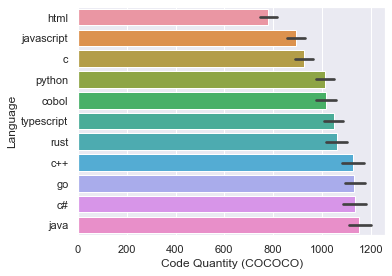

In [10]:
ax = sns.barplot(x="code_quantity", y="language", data=df_ord.sort_values(by='order_quantity'))
ax.set(xlabel='Code Quantity (COCOCO)', ylabel='Language')
plt.subplots_adjust(left=0.7)
plt.tight_layout()
plt.savefig('cococo_comparison.pdf')

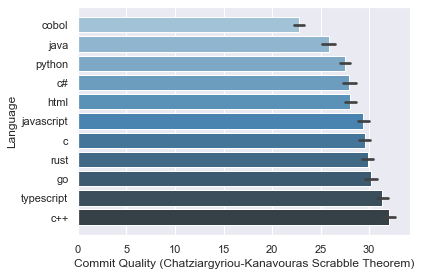

In [11]:
ax = sns.barplot(x="commit_quality", y="language", palette="Blues_d", data=df_ord.sort_values(by='order_quality'))
ax.set(xlabel='Commit Quality (Chatziargyriou-Kanavouras Scrabble Theorem)', ylabel='Language')
plt.plot()
plt.tight_layout()
plt.savefig('scrabble_comparison.pdf')

In [12]:
df.groupby(['language']).corr().loc[:, "code_quantity"].loc[:, "commit_quality"].sort_values()

language
html         -0.016016
c#            0.000648
python        0.010030
rust          0.015572
typescript    0.027002
c++           0.029553
c             0.050015
go            0.050041
javascript    0.075227
java          0.088191
cobol         0.098088
Name: code_quantity, dtype: float64

In [13]:
scrabble = Scrabble()
scrabble.put_best_many(['adding', 'missing', 'image', 'the', 'accompanying', 'text', 'that'])
print(scrabble)

               
     that text 
       c     h 
       c image 
       o  i    
       m  s    
       p  s    
       adding  
       n  n    
       y  g    
       i       
       n       
       g       
               
               



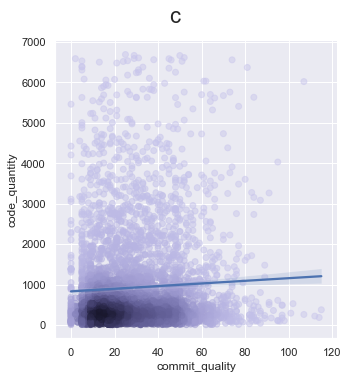

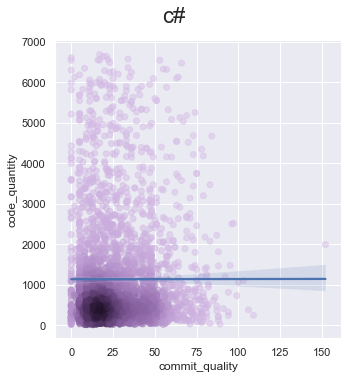

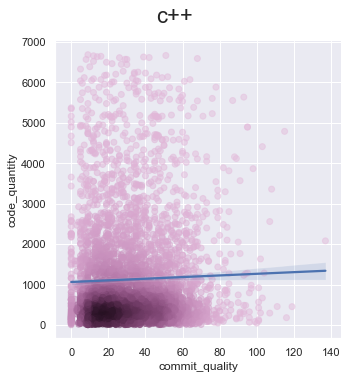

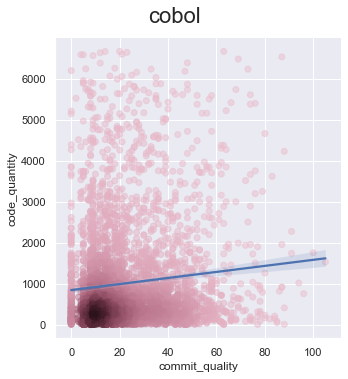

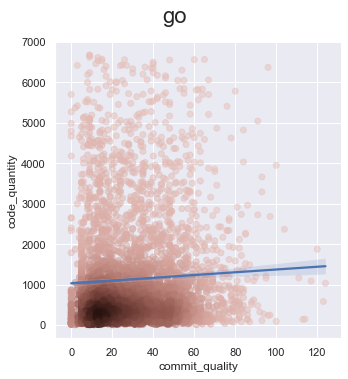

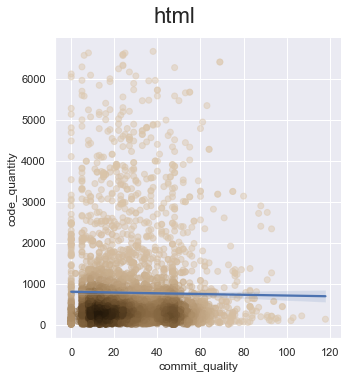

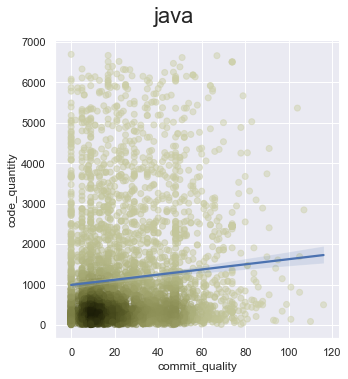

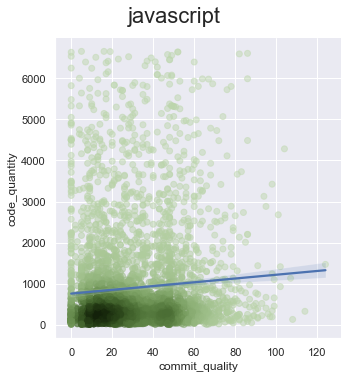

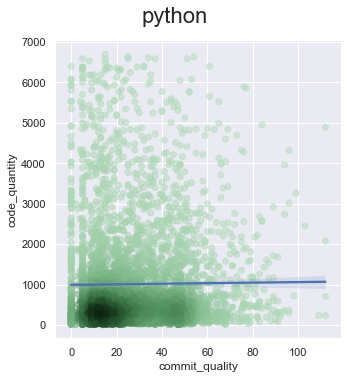

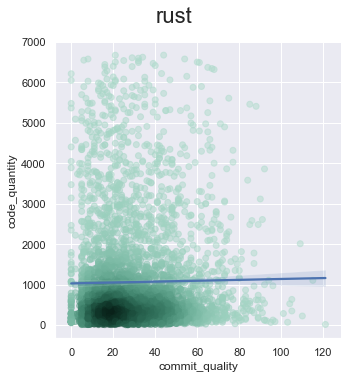

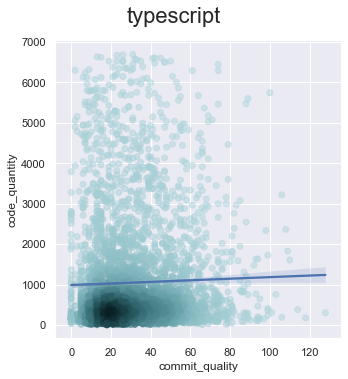

In [14]:
for i, language in enumerate(np.array(pd.Categorical(df['language']).categories)):
    df_lang = df[df["language"] == language]
    num_values = np.vstack([df_lang["code_quantity"], df_lang["commit_quality"]])
    kde = stats.gaussian_kde(num_values)(num_values)
    color_map = sns.cubehelix_palette(start=0.25*i, rot=0, dark=0.1, light=.8, reverse=False, as_cmap=True)
    #scatter_plot = sns.scatterplot(x="commit_quality", y="code_quantity", data=df, c=kde, cmap=color_map, alpha = 0.5, edgecolor=None);
    lmfig = sns.lmplot(x="commit_quality", y="code_quantity", data=df_lang,scatter_kws={'c': kde, 'color': None, 'cmap':color_map, 'alpha':0.5, 'edgecolor':None});
    lmfig.fig.suptitle(language, fontsize=22, y = 1.05);

